In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [6]:
conditions_ = pd.DataFrame({"x1": np.linspace(-3, 3, 7), "x2": np.linspace(-1, 5, 7)})
conditions_

,x1,x2
0,-3.0,-1.0
1,-2.0,0.0
2,-1.0,1.0
3,0.0,2.0
4,1.0,3.0
5,2.0,4.0
6,3.0,5.0


In [101]:
def avoid_negative(condition_pool: pd.DataFrame):
    downvotes = (condition_pool < 0).sum(axis=1)
    with_votes = pd.DataFrame.assign(condition_pool, score=downvotes)
    with_votes_sorted = with_votes.sort_values(by="score", ascending=True)
    return with_votes_sorted

result_1 = avoid_negative(conditions_)

Text(0.5, 1.0, 'Avoid-even function')

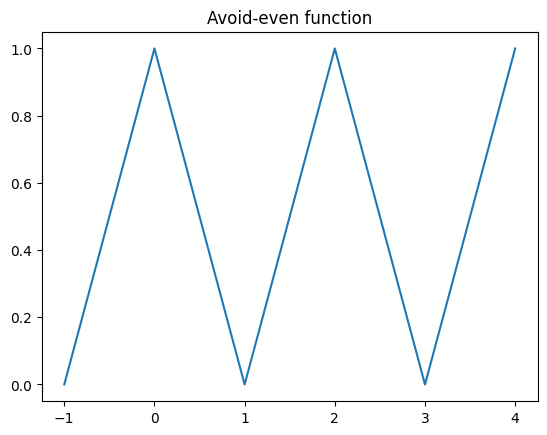

In [24]:
def avoid_even_function(x):
    y = 1 - np.minimum(np.mod(x, 2), np.mod(-x, 2))
    return y

x = np.linspace(-1, 4, 101)
plt.plot(x, avoid_even_function(x))
plt.title("Avoid-even function")

In [102]:
def avoid_even(condition_pool: pd.DataFrame):
    downvotes = avoid_even_function(condition_pool).sum(axis=1)
    with_votes = pd.DataFrame.assign(condition_pool, score=downvotes)
    with_votes_sorted = with_votes.sort_values(by="score", ascending=True)
    return with_votes_sorted

result_2 = avoid_even(conditions_)

In [49]:
result_1.sort_index()


,x1,x2,downvotes
0,-3.0,-1.0,2
1,-2.0,0.0,1
2,-1.0,1.0,1
3,0.0,2.0,0
4,1.0,3.0,0
5,2.0,4.0,0
6,3.0,5.0,0


In [37]:
result_2

,x1,x2,downvotes_2
0,-3.0,-1.0,0.0
2,-1.0,1.0,0.0
4,1.0,3.0,0.0
6,3.0,5.0,0.0
1,-2.0,0.0,2.0
3,0.0,2.0,2.0
5,2.0,4.0,2.0


In [40]:
result_3=result_2.copy(deep=True)

In [47]:
result_3

,x1,x2,downvotes_2
0,-3.0,-1.0,0.0
2,-1.0,1.0,0.0
1,-2.0,0.0,2.0


In [43]:
result_3["x1"]<0

0     True
2     True
4    False
6    False
1     True
3    False
5    False
Name: x1, dtype: bool

In [45]:
result_3 = result_3[result_3["x1"]<0]


In [46]:
result_3

,x1,x2,downvotes_2
0,-3.0,-1.0,0.0
2,-1.0,1.0,0.0
1,-2.0,0.0,2.0


In [64]:
pd.merge(result_1,result_2, left_index=True, right_on = "downvotes_2", how="inner")

,x1_x,x2_x,downvotes,x1_y,x2_y,downvotes_2
1,-1.0,1.0,1,-2.0,0.0,2.0
3,-1.0,1.0,1,0.0,2.0,2.0
5,-1.0,1.0,1,2.0,4.0,2.0
0,-3.0,-1.0,2,-3.0,-1.0,0.0
2,-3.0,-1.0,2,-1.0,1.0,0.0
4,-3.0,-1.0,2,1.0,3.0,0.0
6,-3.0,-1.0,2,3.0,5.0,0.0


In [59]:
result_1

,x1,x2,downvotes
3,0.0,2.0,0
4,1.0,3.0,0
5,2.0,4.0,0
6,3.0,5.0,0
1,-2.0,0.0,1
2,-1.0,1.0,1
0,-3.0,-1.0,2


In [106]:
samplers_with_names = [[avoid_negative, "negative", 0.8], [avoid_even, "even", 0.3]]

In [188]:
"""
Mixture Experimentalist Sampler
"""

import numpy as np
from typing import Optional

import pandas as pd


def adjust_distribution(p, temperature):
    # temperature cannot be 0
    assert temperature != 0, 'Temperature cannot be 0'

    # If the temperature is very low (close to 0), then the sampling will become almost deterministic, picking the event with the highest probability.
    # If the temperature is very high, then the sampling will be closer to uniform, with all events having roughly equal probability.

    p = p / np.sum(p)  # Normalizing the initial distribution
    p = np.exp(p / temperature)
    final_p = p / np.sum(p)  # Normalizing the final distribution
    return final_p


def mixture_sample(condition_pool: Union[pd.DataFrame, np.ndarray], temperature: float, samplers: list, params: dict,
                   num_samples: Optional[int] = None) -> pd.DataFrame:
    """

    Args:
        condition_pool: pool of experimental conditions to evaluate: pd.Dataframe
        temperature: how random is selection of conditions (cannot be 0; (0:1) - the choices are more deterministic than the choices made wrt
        samplers: tuple containing sampler functions, their names, and weights
        for sampler functions that return both positive and negative scores, user can provide a list with two weights: the first one will be applied to positive scores, the second one -- to the negative
        params: nested dictionary. keys correspond to the sampler function names (same as provided in samplers),
        values correspond to the dictionaries of function arguments (argument name: its value)
        num_samples: number of experimental conditions to select

    Returns:
        Sampled pool of experimental conditions with the scores attached to them
    """
    
    condition_pool = pd.DataFrame(condition_pool)

    rankings = pd.DataFrame()
    mixture_scores = np.zeros(len(conditions_))
    ## getting rankings and weighted scores from each function
    for (function, name, weight) in samplers:
        try:
            sampler_params = params[name]
            pd_ranking = function(condition_pool=condition_pool, **sampler_params)
        except:
            pd_ranking = function(condition_pool=condition_pool)
        # sorting by index
        pd_ranking = pd_ranking.sort_index()


        # if only one weight is provided, use it for both negative and positive dimensions
        if isinstance(weight, float) or isinstance(weight, int):
            pd_ranking["score"] = pd_ranking["score"] * weight
        else:
            if len(pd_ranking["score"] < 0) > 0 and len(pd_ranking["score"] > 0) > 0: # there are both positive and negative values

                pd_ranking.loc[pd_ranking["score"] > 0]["score"] = pd_ranking.loc[pd_ranking["score"] > 0]["score"] * weight[
                    0]  # positive dimension gets the first weight
                pd_ranking.loc[pd_ranking["score"] < 0]["score"] = pd_ranking.loc[pd_ranking["score"] < 0]["score"] * weight[1]  # negative dimension gets the second weight
            else:
                pd_ranking["score"] = pd_ranking["score"] * weight[0]

        pd_ranking.rename(columns={"score": f"{name}_score"}, inplace=True)
        # sum_scores are arranged based on the original conditions_ indices
        mixture_scores = mixture_scores + pd_ranking[f"{name}_score"]
        
        rankings = pd.merge(rankings, pd_ranking, left_index=True, right_index=True, how="outer")

    # adjust mixture scores wrt temperature
    weighted_mixture_scores_adjusted = adjust_distribution(mixture_scores, temperature)

    if num_samples is None:
        num_samples = condition_pool.shape[0]

    condition_indices = np.random.choice(np.arange(len(conditions_)), num_samples,
                                  p=weighted_mixture_scores_adjusted, replace=False)
    conditions = conditions_.iloc[condition_indices]
    conditions["score"] = mixture_scores
    
    return conditions

In [189]:
selected_conditions = mixture_sample(
    condition_pool=conditions_,
    temperature=0.01,
    samplers=samplers_with_names,
    params={"negative":None, "even":None},
    num_samples=4
)

/var/folders/xk/2c6fkk5d1vd7qqn6thv9bd_40000gq/T/ipykernel_72867/2804609627.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conditions["score"] = mixture_scores


In [190]:
selected_conditions

,x1,x2,score
0,-3.0,-1.0,1.6
1,-2.0,0.0,1.4
2,-1.0,1.0,0.8
3,0.0,2.0,0.6
